<a href="https://colab.research.google.com/github/sahupra1357/EE628FinalProject/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sahupra1357/EE628FinalProject.git

Cloning into 'EE628FinalProject'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [2]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
!ls

drive  EE628FinalProject  sample_data


In [4]:
import zipfile
zip_ref_train = zipfile.ZipFile("/content/drive/MyDrive/train.zip", 'r')
zip_ref_train.extractall("/data/dogvscat")
zip_ref_train.close()

In [5]:
zip_ref_test = zipfile.ZipFile("/content/drive/MyDrive/test1.zip", 'r')
zip_ref_test.extractall("/data/dogvscat")
zip_ref_test.close()

In [9]:
!ls /data/dogvscat

test1  train


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [8]:
#!ls test	train  valid

ls: cannot access 'test': No such file or directory
ls: cannot access 'train': No such file or directory
ls: cannot access 'valid': No such file or directory


In [126]:
#!rm -rf test	train  valid

In [10]:
!ls

drive  EE628FinalProject  sample_data


In [11]:
# Organize data into train, valid, test dirs
os.chdir('/data')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dogcat')

In [12]:
    for i in random.sample(glob.glob('/data/dogvscat/train/cat*'), 512):
        shutil.copy(i, 'train/cat')      
    for i in random.sample(glob.glob('/data/dogvscat/train/dog*'), 512):
        shutil.copy(i, 'train/dog')
    for i in random.sample(glob.glob('/data/dogvscat/train/cat*'), 128):
        shutil.copy(i, 'valid/cat')        
    for i in random.sample(glob.glob('/data/dogvscat/train/dog*'), 128):
        shutil.copy(i, 'valid/dog')   
    for i in random.sample(glob.glob('/data/dogvscat/test1/*'), 128):
        shutil.copy(i, 'test/dogcat')           

In [13]:
!ls /data/test

dogcat


In [14]:
train_path = '/data/train'
valid_path = '/data/valid'
test_path = '/data/test'

In [15]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=None, batch_size=10, shuffle=False)

Found 1024 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 128 images belonging to 1 classes.


In [16]:
imgs, labels = next(train_batches)

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

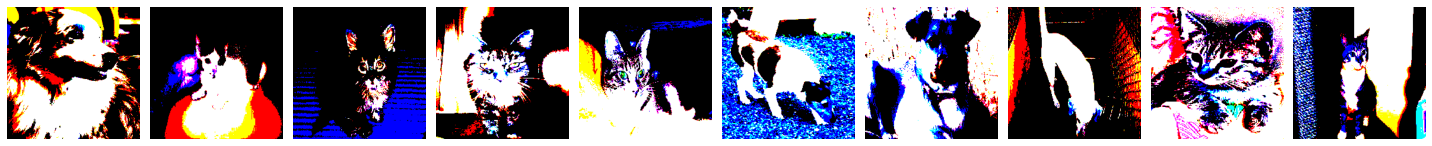

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [18]:
plotImages(imgs)
print(labels)

In [19]:
epochs = 100
batch_size = 32
img_width, img_height = 224, 224

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [21]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

predict_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,)

Found 1024 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 128 images belonging to 1 classes.


In [22]:
print(len(train_generator))

32


In [23]:
import time
start_time=time.time()
#del model
input_shape = (img_width, img_height, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

In [25]:
# fine-tune the model
hist_cnn=model.fit(
                train_generator,
                steps_per_epoch=32 ,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=8)

Epoch 1/100
32/32 [==============================] - 13s 422ms/step - loss: 0.8401 - accuracy: 0.5273 - val_loss: 1.8485 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 13s 407ms/step - loss: 0.7124 - accuracy: 0.5771 - val_loss: 0.6785 - val_accuracy: 0.5195
Epoch 3/100
32/32 [==============================] - 13s 413ms/step - loss: 0.6774 - accuracy: 0.6221 - val_loss: 0.6209 - val_accuracy: 0.6484
Epoch 4/100
32/32 [==============================] - 13s 410ms/step - loss: 0.6599 - accuracy: 0.6309 - val_loss: 0.6530 - val_accuracy: 0.6406
Epoch 5/100
32/32 [==============================] - 13s 410ms/step - loss: 0.6135 - accuracy: 0.6602 - val_loss: 0.6590 - val_accuracy: 0.6445
Epoch 6/100
32/32 [==============================] - 13s 403ms/step - loss: 0.6261 - accuracy: 0.6699 - val_loss: 0.6282 - val_accuracy: 0.6914
Epoch 7/100
32/32 [==============================] - 13s 404ms/step - loss: 0.6311 - accuracy: 0.6904 - val_loss: 0.6473 - val_accuracy:

In [26]:
model.save("/data/my_CNN_model.h5")

In [28]:
import pandas as pd
hist_df=pd.DataFrame(hist_cnn.history)
hist_df.to_csv("/data/my_CNN_model.csv",index_label ='epochs',header=True)
print('history saved')

history saved


In [29]:
hist_cnn.history

{'accuracy': [0.52734375,
  0.5771484375,
  0.6220703125,
  0.630859375,
  0.66015625,
  0.669921875,
  0.6904296875,
  0.69921875,
  0.73046875,
  0.7216796875,
  0.748046875,
  0.75,
  0.748046875,
  0.7666015625,
  0.78125,
  0.791015625,
  0.775390625,
  0.806640625,
  0.798828125,
  0.8076171875,
  0.8046875,
  0.8203125,
  0.8203125,
  0.8115234375,
  0.828125,
  0.830078125,
  0.845703125,
  0.8564453125,
  0.8466796875,
  0.859375,
  0.84765625,
  0.857421875,
  0.8681640625,
  0.8740234375,
  0.8603515625,
  0.87890625,
  0.8642578125,
  0.8466796875,
  0.8798828125,
  0.8837890625,
  0.8623046875,
  0.900390625,
  0.8935546875,
  0.8623046875,
  0.90234375,
  0.888671875,
  0.900390625,
  0.8994140625,
  0.8974609375,
  0.904296875,
  0.9111328125,
  0.919921875,
  0.90234375,
  0.9033203125,
  0.8984375,
  0.90625,
  0.923828125,
  0.9111328125,
  0.8974609375,
  0.9130859375,
  0.90625,
  0.9140625,
  0.9306640625,
  0.9140625,
  0.9111328125,
  0.9306640625,
  0.9345703125

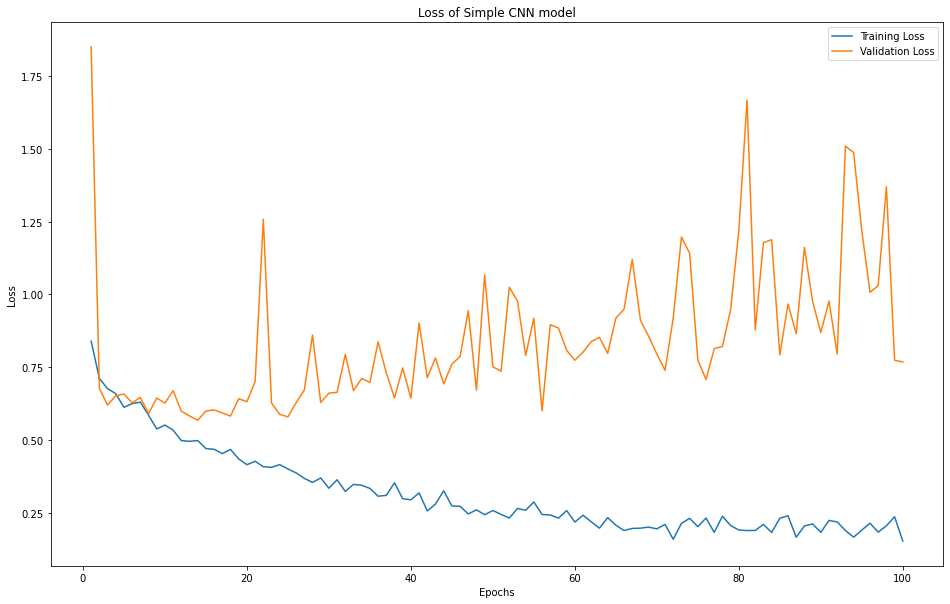

Plot saved


In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10)) 
epochs = range(1, len(hist_cnn.history['accuracy']) + 1)
plt.plot(epochs, hist_cnn.history['loss'], label='Training Loss') 
plt.plot(epochs, hist_cnn.history['val_loss'], label='Validation Loss') 

plt.title('Loss of Simple CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/data/my_CNN_model.jpg")
plt.show()
print('Plot saved')

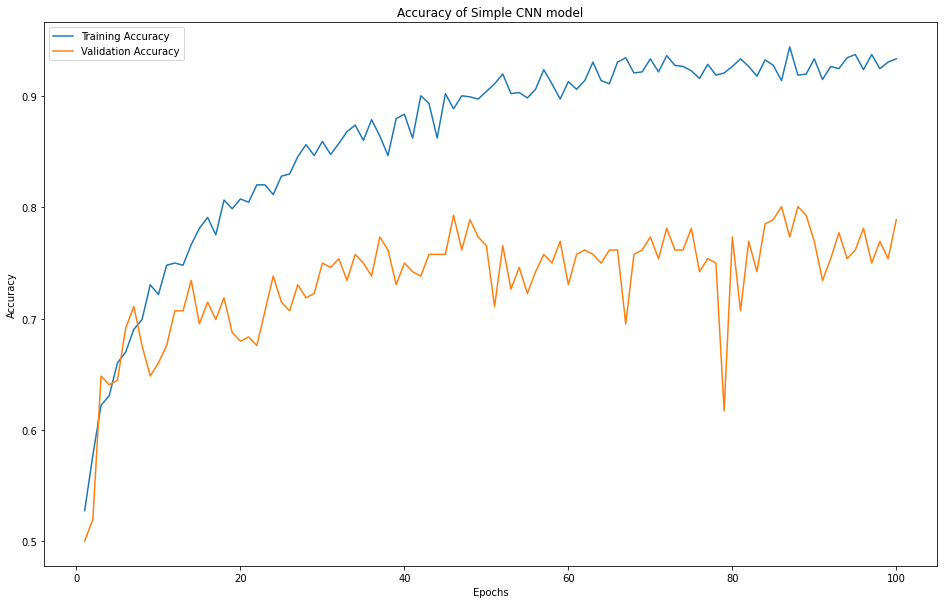

Plot saved


In [32]:
plt.figure(figsize=(16,10)) 
epochs = range(1, len(hist_cnn.history['accuracy']) + 1)
plt.plot(epochs, hist_cnn.history['accuracy'], label='Training Accuracy') 
plt.plot(epochs, hist_cnn.history['val_accuracy'], label='Validation Accuracy') 
plt.title('Accuracy of Simple CNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/data/my_CNN_Accuracy_model.jpg")
plt.show()
print('Plot saved')

In [34]:
!ls

dogvscat		   my_CNN_model.csv  my_CNN_model.jpg  train
my_CNN_Accuracy_model.jpg  my_CNN_model.h5   test	       valid


In [35]:
from google.colab import files
files.download("my_CNN_Accuracy_model.jpg")
files.download("my_CNN_model.csv")
files.download("my_CNN_model.h5")
files.download("my_CNN_model.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>